In [16]:
import sys
import torch
import numpy as np
import torch.nn.functional as F
import ot
import time
import matplotlib.pyplot as plt

sys.path.append('../')
from utils import vmf as vmf_utils
from utils.s3w import RotationPool
from methods import sswd as ssw, s3wd as s3w
from methods import sw as sw2

import gc

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

## Runtime

In [2]:
ntry = 50

kappa = 10
pool_size = 100
n_rot = 10
ds = [101]

samples = [100, 333, 666, int(1e3), int(1e4), int(1e5)]
projs = [200]

test = np.zeros((len(ds), len(projs), len(samples), ntry))
L_aris3wd = np.zeros((len(ds), len(projs), len(samples), ntry))
L_ris3wd = np.zeros((len(ds), len(projs), len(samples), ntry))
L_s3wd = np.zeros((len(ds), len(projs), len(samples), ntry))
L_ssw2 = np.zeros((len(ds), len(projs), len(samples), ntry))
L_unif = np.zeros((len(ds), len(projs), len(samples), ntry))
L_ssw1 = np.zeros((len(ds), len(projs), len(samples), ntry))
L_sw2 = np.zeros((len(ds), len(projs), len(samples), ntry))

L_w = np.zeros((len(ds), len(samples), ntry))
L_s = np.zeros((len(ds), len(samples), ntry))

for i, dim in enumerate(ds):
    print(dim, flush=True)
    
    mu = np.ones((dim,))
    mu = mu/np.linalg.norm(mu)
    
    for k, n_samples in enumerate(samples):
        print(n_samples, flush=True)
        x0 = torch.randn((n_samples, dim), device=device)
        x0 = F.normalize(x0, p=2, dim=-1)
    
        x1 = vmf_utils.rand_vmf(mu, kappa=kappa, N=n_samples)

        s3w.ari_s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=200, device=device, n_rotations=n_rot, pool_size=pool_size)
    
        for j in range(ntry):
            for l, n_projs in enumerate(projs):

                try:
                    t0 = time.time()
                    d = s3w.s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=n_projs, device=device, random_pnp=False)
                    test[i,l,k,j] = time.time()-t0
                except Exception as e:
                    print(e)
                    test[i,l,k,j] = np.inf

                gc.collect()
                torch.cuda.empty_cache()


                try:
                    t0 = time.time()
                    d = s3w.s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=n_projs, device=device, random_pnp=False)
                    L_s3wd[i,l,k,j] = time.time()-t0
                except Exception as e:
                    print(e)
                    L_s3wd[i,l,k,j] = np.inf

                gc.collect()
                torch.cuda.empty_cache()
                

                try:
                    t0 = time.time()
                    d = s3w.ri_s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=n_projs, device=device, n_rotations=n_rot)
                    L_ris3wd[i,l,k,j] = time.time()-t0
                except Exception as e:
                    print(e)
                    L_ris3wd[i,l,k,j] = np.inf

                gc.collect()
                torch.cuda.empty_cache()

                try:
                    t0 = time.time()
                    d = s3w.ari_s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=n_projs, device=device, n_rotations=n_rot, pool_size=pool_size)
                    L_aris3wd[i,l,k,j] = time.time()-t0
                except Exception as e:
                    print(e)
                    L_aris3wd[i,l,k,j] = np.inf

                gc.collect()
                torch.cuda.empty_cache()

                try:
                    t0 = time.time()
                    d = sw.swd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=n_projs, device=device)
                    L_sw2[i,l,k,j] = time.time()-t0
                except Exception as e:
                    print(e)
                    L_sw2[i,l,k,j] = np.inf

                gc.collect()
                torch.cuda.empty_cache()

                try:
                    t0 = time.time()
                    d = ssw.sswd(x0, torch.tensor(x1, dtype=torch.float, device=device), n_projs, device, p=2)
                    L_ssw2[i,l,k,j] = time.time()-t0
                except:
                    L_ssw2[i,l,k,j] = np.inf
                
                gc.collect()
                torch.cuda.empty_cache()
                    
                try:
                    t0 = time.time()
                    d = ssw.sswd(x0, torch.tensor(x1, dtype=torch.float, device=device), n_projs, device, p=1)
                    L_ssw1[i,l,k,j] = time.time()-t0
                except:
                    L_ssw1[i,l,k,j] = np.inf
                
                gc.collect()
                torch.cuda.empty_cache()

                try:
                    t0 = time.time()
                    d = ssw.sswd_unif(torch.tensor(x1, dtype=torch.float, device=device), n_projs, device)
                    L_unif[i,l,k,j] = time.time()-t0
                except:
                    L_unif[i,l,k,j] = np.inf

                gc.collect()
                torch.cuda.empty_cache()

            if n_samples > 2e4:
                L_s[i,k,j] = np.inf
                L_w[i,k,j] = np.inf
                continue

            try:
                t2 = time.time()
                ip = x0@torch.tensor(x1, dtype=torch.float, device=device).T
                M = torch.arccos(torch.clamp(ip, min=-1+1e-5, max=1-1e-5))
                a = torch.ones(x0.shape[0], device=device) / x0.shape[0]
                b = torch.ones(x1.shape[0], device=device) / x1.shape[0]
                w = ot.sinkhorn2(a, b, M, reg=1, numitermax=10000, stopThr=1e-15).item()
                L_s[i,k,j] = time.time()-t2
            except:
                L_s[i,k,j] = np.inf

            try:
                t1 = time.time()
                ip = x0@torch.tensor(x1, dtype=torch.float, device=device).T
                M = torch.arccos(torch.clamp(ip, min=-1+1e-5, max=1-1e-5))
                a = torch.ones(x0.shape[0], device=device) / x0.shape[0]
                b = torch.ones(x1.shape[0], device=device) / x1.shape[0]
                w = ot.emd2(a, b, M).item()
                L_w[i,k,j] = time.time()-t1
            except:
                L_w[i,k,j] = np.inf

101
100


333
666
1000
10000


/home/kothapa/miniconda3/envs/dev/lib/python3.11/site-packages/ot/lp/__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


100000


/home/kothapa/miniconda3/envs/dev/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


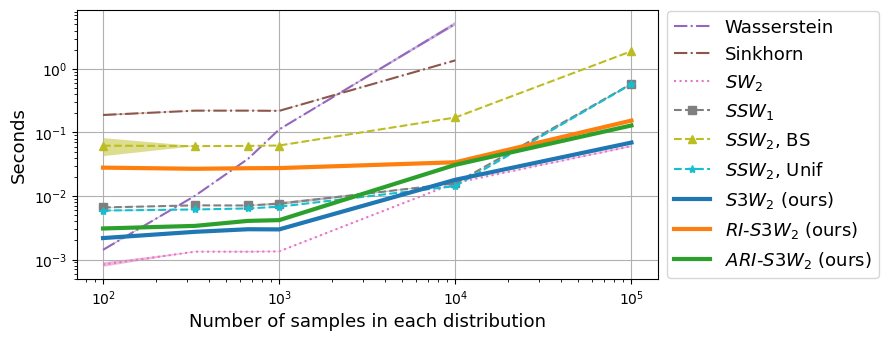

In [4]:
import cycler
default_cycle = plt.rcParams['axes.prop_cycle']
plt.rcParams['axes.prop_cycle'] = cycler.Cycler((np.roll(default_cycle, -4)))

fig = plt.figure(figsize=(7.5,3.5))

for i, d in enumerate([3]):

    m_w = np.mean(L_w[i], axis=-1)
    s_w = np.std(L_w[i], axis=-1)

    plt.loglog(samples, m_w, label=r"Wasserstein", linestyle='dashdot')
    plt.fill_between(samples, m_w-s_w, m_w+s_w, alpha=0.5)


    m_s = np.mean(L_s[i], axis=-1)
    s_s = np.std(L_s[i], axis=-1)

    plt.loglog(samples, m_s, label=r"Sinkhorn", linestyle='dashdot')
    plt.fill_between(samples, m_s-s_s, m_s+s_s, alpha=0.5)

    for l, n_projs in enumerate([200]):

        m = np.mean(L_sw2[i, l], axis=-1)
        s = np.std(L_sw2[i, l], axis=-1)
        plt.plot(samples, m, label=r"$SW_2$", linestyle='dotted') # + r", $L=$"+str(n_projs)
        plt.fill_between(samples, m-s, m+s,alpha=0.5)

        m = np.mean(L_ssw1[i, l], axis=-1)
        s = np.std(L_ssw1[i, l], axis=-1)
        plt.plot(samples, m, label=r"$SSW_1$", linestyle='dashed', marker='s') # + r" $L=$"+str(n_projs)
        plt.fill_between(samples, m-s, m+s,alpha=0.5)

        m = np.mean(L_ssw2[i, l], axis=-1)
        s = np.std(L_ssw2[i, l], axis=-1)

        plt.plot(samples, m, label=r"$SSW_2$, BS", linestyle='dashed', marker='^') # + r" $L=$"+str(n_projs)
        plt.fill_between(samples, m-s, m+s,alpha=0.5)

        m = np.mean(L_unif[i, l], axis=-1)
        s = np.std(L_unif[i, l], axis=-1)

        plt.plot(samples, m, label=r"$SSW_2$, Unif", linestyle='dashed', marker='*') # + r" $L=$"+str(n_projs)
        plt.fill_between(samples, m-s, m+s,alpha=0.5)

        m = np.mean(L_s3wd[i, l], axis=-1)
        s = np.std(L_s3wd[i, l], axis=-1)
        plt.plot(samples, m, label=r"$S3W_2$ (ours)", zorder=200, linewidth=3) # + r", $L=$"+str(n_projs)
        plt.fill_between(samples, m-s, m+s,alpha=0.5)

        m = np.mean(L_ris3wd[i, l], axis=-1)
        s = np.std(L_ris3wd[i, l], axis=-1)
        plt.plot(samples, m, label=r"$RI$-$S3W_2$ (ours)", zorder=100, linewidth=3) # + r", $R=$10," + r" $L=$"+str(n_projs)
        plt.fill_between(samples, m-s, m+s,alpha=0.5)

        m = np.mean(L_aris3wd[i, l], axis=-1)
        s = np.std(L_aris3wd[i, l], axis=-1)
        plt.plot(samples, m, label=r"$ARI$-$S3W_2$ (ours)", zorder=100, linewidth=3) # + r", $R=$10," + r" $L=$"+str(n_projs)
        plt.fill_between(samples, m-s, m+s,alpha=0.5)
        

plt.xlabel("Number of samples in each distribution", fontsize=13)
plt.ylabel("Seconds", fontsize=13)
#     plt.yscale("log")
    # plt.xscale("log")
    
plt.legend(fontsize=13, bbox_to_anchor=(1,0.5), loc="center left", ncol=1)
# plt.title("Computational Time", fontsize=13)
plt.grid(True)
plt.savefig("./Runtime_ComparisonFinal6.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.rcParams['axes.prop_cycle'] = default_cycle

## vMF Evolution Plots

3
25
50
100


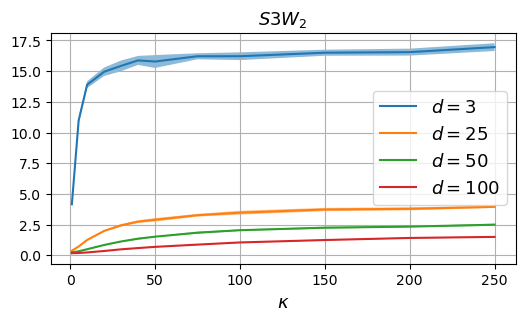

In [ ]:
fig = plt.figure(figsize=(6,3))

for d in [3,25,50,100]:
    print(d)

    x0 = torch.randn((500,d), device=device)
    x0 = F.normalize(x0, p=2, dim=-1)

    kappas = [1,5,10,20,30,40,50,75,100,150,200,250]
    mus = np.ones((len(kappas),d))

    L = np.zeros((len(kappas), 10))

    for k in range(len(kappas)):
        mu = mus[k]
        mu = mu/np.linalg.norm(mu)
        x1 = vmf_utils.rand_vmf(mu,kappa=kappas[k],N=500)

        for j in range(10):
            dist = s3w.s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=200, device=device) ** 0.5
            L[k, j] = dist

    m = np.mean(L, axis=-1)
    s = np.std(L, axis=-1)
    plt.plot(kappas, m, label=r"$d=$"+str(d)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(kappas, m-s, m+s,alpha=0.5)

plt.xlabel(r"$\kappa$", fontsize=13)
plt.title(r"$S3W_2$", fontsize=13) # rotation=0, labelpad=20, fontsize=13)
plt.grid(True)
plt.legend(fontsize=13)
plt.savefig("./S3W_vMF_Evolution.pdf", format="pdf", bbox_inches="tight")
plt.show()

3
25
50
100


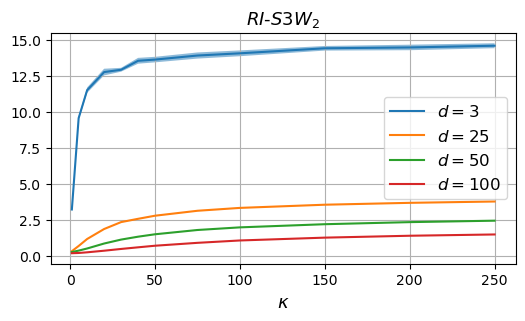

In [ ]:
fig = plt.figure(figsize=(6,3))

for d in [3,25,50,100]:
    print(d)

    x0 = torch.randn((500,d), device=device)
    x0 = F.normalize(x0, p=2, dim=-1)

    kappas = [1,5,10,20,30,40,50,75,100,150,200,250]
    mus = np.ones((len(kappas),d))

    L = np.zeros((len(kappas), 10))

    for k in range(len(kappas)):
        mu = mus[k]
        mu = mu/np.linalg.norm(mu)
        x1 = vmf_utils.rand_vmf(mu,kappa=kappas[k],N=500)

        for j in range(10):
            dist = s3w.ri_s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=200, device=device, n_rotations=100) ** 0.5
            L[k, j] = dist

    m = np.mean(L, axis=-1)
    s = np.std(L, axis=-1)
    plt.plot(kappas, m, label=r"$d=$"+str(d)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(kappas, m-s, m+s,alpha=0.5)
    
plt.xlabel(r"$\kappa$", fontsize=13)
plt.title(r"$RI$-$S3W_2$", fontsize=13) # rotation=0, labelpad=20, fontsize=13)
plt.grid(True)
plt.legend(fontsize=12, loc="center right")
plt.savefig("./RI_S3W_vMF_Evolution.pdf", format="pdf", bbox_inches="tight")
plt.draw()

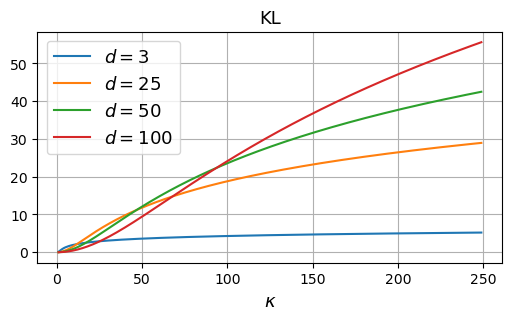

In [ ]:
from scipy.special import iv, gamma

fig = plt.figure(figsize=(6,3))

def KL(k, d):
    cpt1 = k * iv(d/2, k)/iv(d/2-1, k)
    cpt2 = (d/2-1)*np.log(k)
    cpt3  = -np.log(2*np.pi)*d/2 - np.log(iv(d/2-1, k))
    cpt4 = np.log(np.pi)*d/2 + np.log(2) - np.log(gamma(d/2))
    return cpt1+cpt2+cpt3+cpt4

for d in [3,25,50,100]:

    x0 = torch.randn((500,d))
    x0 = F.normalize(x0, p=2, dim=-1)

    kappas = range(1,250) # [1,5,10,20,50,100,200,250]
    mus = np.ones((len(kappas),d))

    L = np.zeros((len(kappas)))

    for k in range(len(kappas)):
        L[k] = KL(kappas[k], d)
            
    plt.plot(kappas, L, label=r"$d=$"+str(d)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    
plt.xlabel(r"$\kappa$", fontsize=13)
plt.legend(fontsize=13)
plt.title("KL", fontsize=13)
plt.grid(True)
plt.savefig("./KL_vMF_Evolution.pdf", format="pdf", bbox_inches="tight")
plt.show()

3
25
50
100


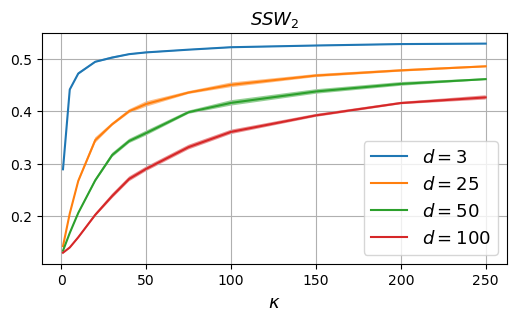

In [ ]:
fig = plt.figure(figsize=(6,3))

for d in [3,25,50,100]:
    print(d)

    x0 = torch.randn((500,d), device=device)
    x0 = F.normalize(x0, p=2, dim=-1)

    kappas = [1,5,10,20,30,40,50,75,100,150,200,250]
    mus = np.ones((len(kappas),d))

    L = np.zeros((len(kappas), 10))

    for k in range(len(kappas)):
        mu = mus[k]
        mu = mu/np.linalg.norm(mu)
        x1 = vmf_utils.rand_vmf(mu,kappa=kappas[k],N=500)

        for j in range(10):
            dist = torch.sqrt(ssw.sswd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, num_projections=200, device=device)) ** 0.5
            L[k, j] = dist

    m = np.mean(L, axis=-1)
    s = np.std(L, axis=-1)
    plt.plot(kappas, m, label=r"$d=$"+str(d)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(kappas, m-s, m+s,alpha=0.5)

plt.xlabel(r"$\kappa$", fontsize=13)
plt.title(r"$SSW_2$", fontsize=13) # rotation=0, labelpad=20, fontsize=13)
plt.grid(True)
plt.legend(fontsize=13)
plt.savefig("./SSW_vMF_Evolution.pdf", format="pdf", bbox_inches="tight")
plt.show()

3
25
50
100


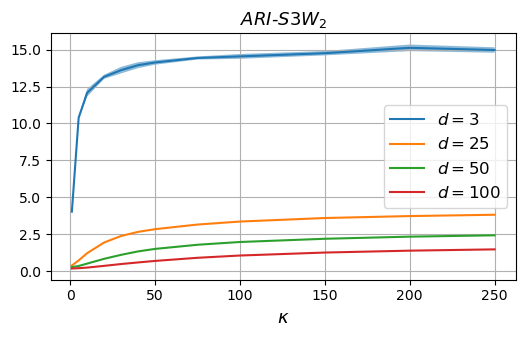

In [ ]:
fig = plt.figure(figsize=(6,3.2))

for d in [3,25,50,100]:
    print(d)

    x0 = torch.randn((500,d), device=device)
    x0 = F.normalize(x0, p=2, dim=-1)

    kappas = [1,5,10,20,30,40,50,75,100,150,200,250]
    mus = np.ones((len(kappas),d))

    L = np.zeros((len(kappas), 10))

    for k in range(len(kappas)):
        mu = mus[k]
        mu = mu/np.linalg.norm(mu)
        x1 = vmf_utils.rand_vmf(mu,kappa=kappas[k],N=500)

        for j in range(10):
            dist = s3w.ari_s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=200, device=device, n_rotations=100, pool_size=1000) ** 0.5
            L[k, j] = dist

    m = np.mean(L, axis=-1)
    s = np.std(L, axis=-1)
    plt.plot(kappas, m, label=r"$d=$"+str(d)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(kappas, m-s, m+s,alpha=0.5)
    
plt.xlabel(r"$\kappa$", fontsize=13)
plt.title(r"$ARI$-$S3W_2$", fontsize=13) # rotation=0, labelpad=20, fontsize=13)
plt.grid(True)
plt.legend(fontsize=12, loc="center right")
plt.savefig("./ARI_S3W_vMF_Evolution.pdf", format="pdf", bbox_inches="tight")
plt.draw()

## Rotation on Sphere

3
25
50


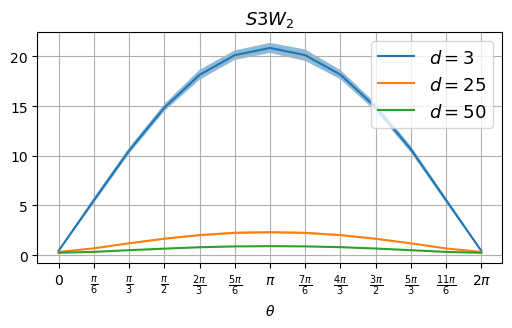

In [ ]:
kappa = 10    

ds = [3, 25, 50]

thetas = [0,np.pi/6,np.pi/3,np.pi/2,2*np.pi/3,5*np.pi/6,np.pi,
            -5*np.pi/6,-2*np.pi/3,-np.pi/2,-np.pi/3,-np.pi/6, 0]
thetas = np.array(thetas)%(2*np.pi)
thetas[-1] = 2*np.pi

L = np.zeros((len(ds), len(thetas), 100))

fig = plt.figure(figsize=(6,3))

for i, d in enumerate(ds):
    print(d)
    
    mu_target = np.zeros((d,))
    mu_target[0] = 1
    
    v = np.zeros((d,))
    v[1] = 1

    mus = []
    for theta in thetas:
        mus.append(np.zeros((d,)))
        mus[-1][0] = np.cos(theta)
        mus[-1][1] = np.sin(theta)
        # mus.append([np.cos(theta), np.sin(theta), 0])    
        
    for k in range(len(mus)):
        mu = np.array(mus[k])
        
        for j in range(100):
            x0 = vmf_utils.rand_vmf(mu_target, kappa=10, N=500)
            x1 = vmf_utils.rand_vmf(mu, kappa=10, N=500)
            sw = s3w.s3wd(torch.tensor(x0, dtype=torch.float, device=device), 
                          torch.tensor(x1, dtype=torch.float, device=device), 
                          n_projs=200, device=device, p=2) ** 0.5
            L[i, k, j] = sw

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)
    plt.plot(thetas, m, label=r"$d=$"+str(d))
    plt.fill_between(thetas, m-s, m+s,alpha=0.5)
    
plt.xlabel(r"$\theta$") 
labels = ["0", r"$\frac{\pi}{6}$", r"$\frac{\pi}{3}$", r"$\frac{\pi}{2}$", r"$\frac{2\pi}{3}$", r"$\frac{5\pi}{6}$",
            r"$\pi$", r"$\frac{7\pi}{6}$", r"$\frac{4\pi}{3}$", r"$\frac{3\pi}{2}$", r"$\frac{5\pi}{3}$",
            r"$\frac{11\pi}{6}$", r"$2\pi$"]
plt.xticks(thetas, labels, fontsize=10)
plt.title(r"$S3W_2$", fontsize=13)
plt.grid(True)
# put legend on top right
plt.legend(fontsize=13, loc="upper right")
plt.savefig("./S3W_vMF_Rotation.pdf", format="pdf", bbox_inches="tight")
plt.show()

3
25
50


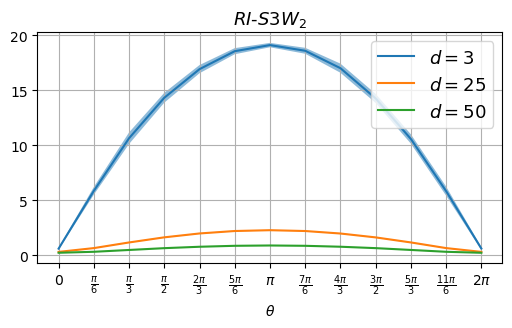

In [ ]:
kappa = 10    

ds = [3, 25, 50]

thetas = [0,np.pi/6,np.pi/3,np.pi/2,2*np.pi/3,5*np.pi/6,np.pi,
            -5*np.pi/6,-2*np.pi/3,-np.pi/2,-np.pi/3,-np.pi/6, 0]
thetas = np.array(thetas)%(2*np.pi)
thetas[-1] = 2*np.pi

L = np.zeros((len(ds), len(thetas), 100))

fig = plt.figure(figsize=(6,3))

for i, d in enumerate(ds):
    print(d)
    
    mu_target = np.zeros((d,))
    mu_target[0] = 1
    
    v = np.zeros((d,))
    v[1] = 1

    mus = []
    for theta in thetas:
        mus.append(np.zeros((d,)))
        mus[-1][0] = np.cos(theta)
        mus[-1][1] = np.sin(theta)
        
    for k in range(len(mus)):
        mu = np.array(mus[k])
        
        for j in range(100):
            x0 = vmf_utils.rand_vmf(mu_target, kappa=10, N=500)
            x1 = vmf_utils.rand_vmf(mu, kappa=10, N=500)
            sw = s3w.ri_s3wd(torch.tensor(x0, dtype=torch.float, device=device), 
                             torch.tensor(x1, dtype=torch.float, device=device), 
                             n_projs=200, n_rotations=100, device=device, p=2) ** 0.5
            L[i, k, j] = sw

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)
    plt.plot(thetas, m, label=r"$d=$"+str(d))
    plt.fill_between(thetas, m-s, m+s,alpha=0.5)
    
plt.xlabel(r"$\theta$") 
labels = ["0", r"$\frac{\pi}{6}$", r"$\frac{\pi}{3}$", r"$\frac{\pi}{2}$", r"$\frac{2\pi}{3}$", r"$\frac{5\pi}{6}$",
            r"$\pi$", r"$\frac{7\pi}{6}$", r"$\frac{4\pi}{3}$", r"$\frac{3\pi}{2}$", r"$\frac{5\pi}{3}$",
            r"$\frac{11\pi}{6}$", r"$2\pi$"]
plt.xticks(thetas, labels, fontsize=10)
plt.title(r"$RI$-$S3W_2$", fontsize=13)
plt.grid(True)
# put legend on top right
plt.legend(fontsize=13, loc="upper right")
plt.savefig("./RI_S3W_vMF_Rotation.pdf", format="pdf", bbox_inches="tight")
plt.show()

3
25
50


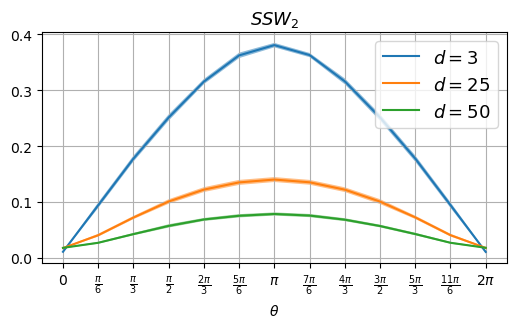

In [ ]:
kappa = 10    

ds = [3, 25, 50]

thetas = [0,np.pi/6,np.pi/3,np.pi/2,2*np.pi/3,5*np.pi/6,np.pi,
            -5*np.pi/6,-2*np.pi/3,-np.pi/2,-np.pi/3,-np.pi/6, 0]
thetas = np.array(thetas)%(2*np.pi)
thetas[-1] = 2*np.pi

L = np.zeros((len(ds), len(thetas), 100))

fig = plt.figure(figsize=(6,3))

for i, d in enumerate(ds):
    print(d)
    
    mu_target = np.zeros((d,))
    mu_target[0] = 1
    
    v = np.zeros((d,))
    v[1] = 1

    mus = []
    for theta in thetas:
        mus.append(np.zeros((d,)))
        mus[-1][0] = np.cos(theta)
        mus[-1][1] = np.sin(theta)
        # mus.append([np.cos(theta), np.sin(theta), 0])    
        
    for k in range(len(mus)):
        mu = np.array(mus[k])
        
        for j in range(100):
            x0 = vmf_utils.rand_vmf(mu_target, kappa=10, N=500)
            x1 = vmf_utils.rand_vmf(mu, kappa=10, N=500)
            sw = ssw.sswd(torch.tensor(x0, dtype=torch.float, device=device), 
                          torch.tensor(x1, dtype=torch.float, device=device), 
                          num_projections=200, device=device, p=2) ** 0.5
            L[i, k, j] = sw

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)
    plt.plot(thetas, m, label=r"$d=$"+str(d))
    plt.fill_between(thetas, m-s, m+s,alpha=0.5)
    
plt.xlabel(r"$\theta$") 
labels = ["0", r"$\frac{\pi}{6}$", r"$\frac{\pi}{3}$", r"$\frac{\pi}{2}$", r"$\frac{2\pi}{3}$", r"$\frac{5\pi}{6}$",
            r"$\pi$", r"$\frac{7\pi}{6}$", r"$\frac{4\pi}{3}$", r"$\frac{3\pi}{2}$", r"$\frac{5\pi}{3}$",
            r"$\frac{11\pi}{6}$", r"$2\pi$"]
plt.xticks(thetas, labels, fontsize=10)
plt.title(r"$SSW_2$", fontsize=13)
plt.grid(True)
# put legend on top right
plt.legend(fontsize=13, loc="upper right")
plt.savefig("./SSW_vMF_Rotation.pdf", format="pdf", bbox_inches="tight")
plt.show()

3
25
50


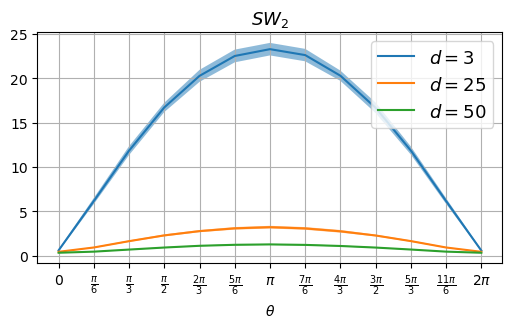

In [ ]:
kappa = 10    

ds = [3, 25, 50]

thetas = [0,np.pi/6,np.pi/3,np.pi/2,2*np.pi/3,5*np.pi/6,np.pi,
            -5*np.pi/6,-2*np.pi/3,-np.pi/2,-np.pi/3,-np.pi/6, 0]
thetas = np.array(thetas)%(2*np.pi)
thetas[-1] = 2*np.pi

L = np.zeros((len(ds), len(thetas), 100))

fig = plt.figure(figsize=(6,3))

for i, d in enumerate(ds):
    print(d)
    
    mu_target = np.zeros((d,))
    mu_target[0] = 1
    
    v = np.zeros((d,))
    v[1] = 1

    mus = []
    for theta in thetas:
        mus.append(np.zeros((d,)))
        mus[-1][0] = np.cos(theta)
        mus[-1][1] = np.sin(theta)
        # mus.append([np.cos(theta), np.sin(theta), 0])    
        
    for k in range(len(mus)):
        mu = np.array(mus[k])
        
        for j in range(100):
            x0 = vmf_utils.rand_vmf(mu_target, kappa=10, N=500)
            x1 = vmf_utils.rand_vmf(mu, kappa=10, N=500)
            sw = sw2.swd(torch.tensor(x0, dtype=torch.float, device=device), 
                          torch.tensor(x1, dtype=torch.float, device=device), 
                          n_projs=200, device=device, p=2) ** 0.5
            L[i, k, j] = sw

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)
    plt.plot(thetas, m, label=r"$d=$"+str(d))
    plt.fill_between(thetas, m-s, m+s,alpha=0.5)
    
plt.xlabel(r"$\theta$") 
labels = ["0", r"$\frac{\pi}{6}$", r"$\frac{\pi}{3}$", r"$\frac{\pi}{2}$", r"$\frac{2\pi}{3}$", r"$\frac{5\pi}{6}$",
            r"$\pi$", r"$\frac{7\pi}{6}$", r"$\frac{4\pi}{3}$", r"$\frac{3\pi}{2}$", r"$\frac{5\pi}{3}$",
            r"$\frac{11\pi}{6}$", r"$2\pi$"]
plt.xticks(thetas, labels, fontsize=10)
plt.title(r"$SW_2$", fontsize=13)
plt.grid(True)
# put legend on top right
plt.legend(fontsize=13, loc="upper right")
plt.savefig("./SW_vMF_Rotation.pdf", format="pdf", bbox_inches="tight")
plt.show()

3
25
50


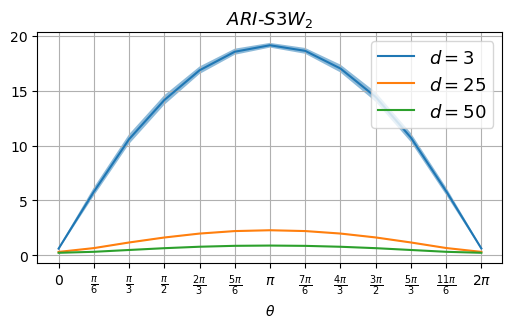

In [ ]:
kappa = 10    

ds = [3, 25, 50]

thetas = [0,np.pi/6,np.pi/3,np.pi/2,2*np.pi/3,5*np.pi/6,np.pi,
            -5*np.pi/6,-2*np.pi/3,-np.pi/2,-np.pi/3,-np.pi/6, 0]
thetas = np.array(thetas)%(2*np.pi)
thetas[-1] = 2*np.pi

L = np.zeros((len(ds), len(thetas), 100))

fig = plt.figure(figsize=(6,3))

for i, d in enumerate(ds):
    print(d)
    
    mu_target = np.zeros((d,))
    mu_target[0] = 1
    
    v = np.zeros((d,))
    v[1] = 1

    mus = []
    for theta in thetas:
        mus.append(np.zeros((d,)))
        mus[-1][0] = np.cos(theta)
        mus[-1][1] = np.sin(theta)
        
    for k in range(len(mus)):
        mu = np.array(mus[k])
        
        for j in range(100):
            x0 = vmf_utils.rand_vmf(mu_target, kappa=10, N=500)
            x1 = vmf_utils.rand_vmf(mu, kappa=10, N=500)
            sw = s3w.ari_s3wd(torch.tensor(x0, dtype=torch.float, device=device), 
                             torch.tensor(x1, dtype=torch.float, device=device), 
                             n_projs=200, n_rotations=100, device=device, p=2, pool_size=1000) ** 0.5
            L[i, k, j] = sw

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)
    plt.plot(thetas, m, label=r"$d=$"+str(d))
    plt.fill_between(thetas, m-s, m+s,alpha=0.5)
    
plt.xlabel(r"$\theta$") 
labels = ["0", r"$\frac{\pi}{6}$", r"$\frac{\pi}{3}$", r"$\frac{\pi}{2}$", r"$\frac{2\pi}{3}$", r"$\frac{5\pi}{6}$",
            r"$\pi$", r"$\frac{7\pi}{6}$", r"$\frac{4\pi}{3}$", r"$\frac{3\pi}{2}$", r"$\frac{5\pi}{3}$",
            r"$\frac{11\pi}{6}$", r"$2\pi$"]
plt.xticks(thetas, labels, fontsize=10)
plt.title(r"$ARI$-$S3W_2$", fontsize=13)
plt.grid(True)
# put legend on top right
plt.legend(fontsize=13, loc="upper right")
plt.savefig("./ARI_S3W_vMF_Rotation.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Evolution w.r.t projections, rotations

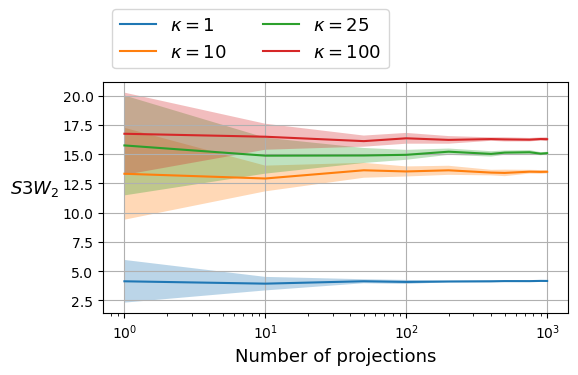

In [ ]:
fig = plt.figure(figsize=(6,3))

d = 3

x0 = torch.randn((500,d), device=device)
x0 = F.normalize(x0, p=2, dim=-1)

kappas = [1, 10, 25, 100]
mus = np.ones((len(kappas),d))
projs = [1,10,50,100,200,400,500,750,900,1000]

L = np.zeros((len(kappas),len(projs),20))

for i, k in enumerate(kappas):
    mu = mus[i]
    mu = mu/np.linalg.norm(mu)
    x1 = vmf_utils.rand_vmf(mu,kappa=k,N=500)

    for l, n_projs in enumerate(projs):
        for j in range(20):
            sw = s3w.s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=n_projs, device=device) ** 0.5
            L[i,l,j] = sw

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)
    
    plt.plot(projs, m, label=r"$\kappa=$"+str(k)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(projs, m-s, m+s,alpha=0.3)
    plt.xlabel("Number of projections", fontsize=13)
#     plt.yscale("log")
    plt.xscale("log")

# plt.title(r"$SSW_2^2$", fontsize=13)
plt.ylabel(r"$S3W_2$", fontsize=13, rotation=0, labelpad=20)
plt.grid(True)
plt.legend(fontsize=13, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2)
plt.savefig("./S3W_Projection_Evol_Kappa.pdf", format="pdf", bbox_inches="tight")
plt.show()

3
100
500
1000
2000


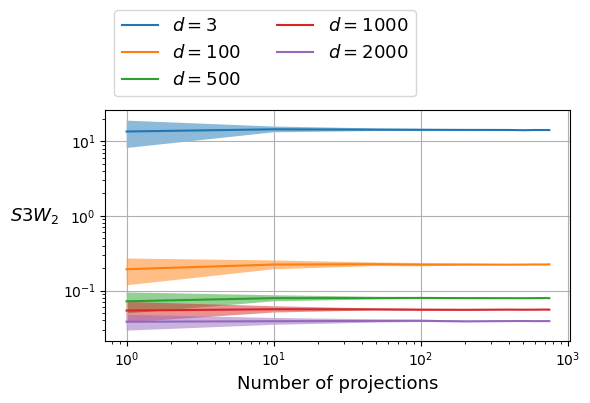

In [ ]:
fig = plt.figure(figsize=(6,3))

kappa = 10
ds = [3, 10, 50, 100, 500, 1000]
projs = [1,10,50,100,200,400,500,600,700,750]

L = np.zeros((len(ds), len(projs), 20))

for i, d in enumerate(ds):
    print(d)
    x0 = torch.randn((500,d), device=device)
    x0 = F.normalize(x0, p=2, dim=-1)
    
    mu = np.ones((d,))
    mu = mu/np.linalg.norm(mu)
    x1 = vmf_utils.rand_vmf(mu, kappa=kappa, N=500)
    
    for l, n_projs in enumerate(projs):
        # print(n_projs)
        for j in range(20):
            sw = s3w.s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=n_projs, device=device) ** 0.5
            L[i,l,j] = sw

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)

    plt.plot(projs, m, label=r"$d=$"+str(d)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(projs, m-s, m+s,alpha=0.5)

plt.xlabel("Number of projections", fontsize=13)
plt.ylabel(r"$S3W_2$", fontsize=13, rotation=0, labelpad=20)
plt.yscale("log")
plt.xscale("log")
    
plt.legend(fontsize=13, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2)
plt.grid(True)
plt.savefig("./S3W_Projection_Evol_Dim2.pdf", format="pdf", bbox_inches="tight")
plt.show()

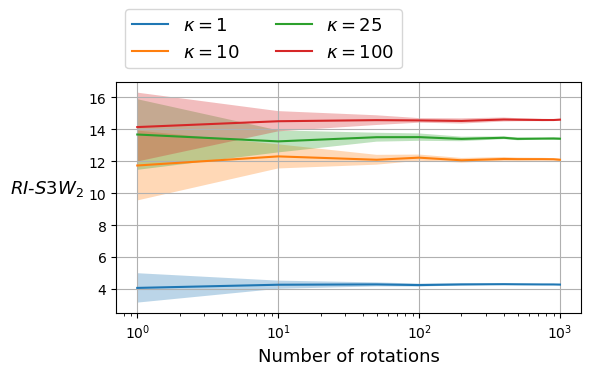

In [ ]:
fig = plt.figure(figsize=(6,3))

d = 3

x0 = torch.randn((500,d), device=device)
x0 = F.normalize(x0, p=2, dim=-1)

kappas = [1, 10, 25, 100]
mus = np.ones((len(kappas),d))
rots = [1,10,50,100,200,400,500,750,900,1000]

L = np.zeros((len(kappas),len(rots),20))

for i, k in enumerate(kappas):
    mu = mus[i]
    mu = mu/np.linalg.norm(mu)
    x1 = vmf_utils.rand_vmf(mu,kappa=k,N=500)

    for l, n_rots in enumerate(rots):
        for j in range(20):
            sw = s3w.ri_s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=10, device=device, n_rotations=n_rots) ** 0.5
            L[i,l,j] = sw

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)
    
    plt.plot(rots, m, label=r"$\kappa=$"+str(k)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(rots, m-s, m+s,alpha=0.3)
    plt.xlabel("Number of rotations", fontsize=13)
#     plt.yscale("log")
    plt.xscale("log")

# plt.title(r"$SSW_2^2$", fontsize=13)
plt.ylabel(r"$RI$-$S3W_2$", fontsize=13, rotation=0, labelpad=30)
plt.grid(True)
plt.legend(fontsize=13, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2)
plt.savefig("./RIS3W_Rotation_Evol.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,3))

kappa = 10
ds = [3, 10, 50, 100, 500, 1000]
rots = [1,10,50,100,200,400,500,600,700,750,1000]

L = np.zeros((len(ds), len(rots), 20))

for i, d in enumerate(ds):
    print(d)
    x0 = torch.randn((500,d), device=device)
    x0 = F.normalize(x0, p=2, dim=-1)
    
    mu = np.ones((d,))
    mu = mu/np.linalg.norm(mu)
    x1 = vmf_utils.rand_vmf(mu, kappa=kappa, N=500)
    
    for l, n_rots in enumerate(rots):
        for j in range(20):
            sw = s3w.ri_s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_rotations=n_rots, device=device, n_projs=10) ** 0.5
            L[i,l,j] = sw

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)

    plt.plot(rots, m, label=r"$d=$"+str(d)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(rots, m-s, m+s,alpha=0.5)

plt.xlabel("Number of rotations", fontsize=13)
plt.ylabel(r"$RI$-$S3W_2$", fontsize=13, rotation=0, labelpad=30)
plt.yscale("log")
plt.xscale("log")
    
plt.legend(fontsize=13, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2)
plt.grid(True)
plt.savefig("./RI_S3W_Projection_Evol_Dim.pdf", format="pdf", bbox_inches="tight")
plt.show()

3
10
50
100
500
1000


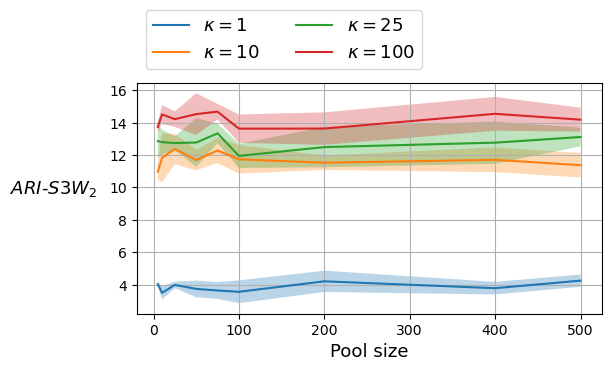

In [3]:
fig = plt.figure(figsize=(6,3))

d = 3

x0 = torch.randn((500,d), device=device)
x0 = F.normalize(x0, p=2, dim=-1)

kappas = [1, 10, 25, 100]
mus = np.ones((len(kappas),d))
pools = [5,10,25,50,75,100,200,400,500]

L = np.zeros((len(kappas),len(pools),5))

for i, k in enumerate(kappas):
    mu = mus[i]
    mu = mu/np.linalg.norm(mu)
    x1 = vmf_utils.rand_vmf(mu,kappa=k,N=500)

    for l, n_pools in enumerate(pools):
        for j in range(5):
            sw = s3w.ari_s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=5, device=device, n_rotations=5, pool_size=n_pools) ** 0.5
            L[i,l,j] = sw

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)
    
    plt.plot(pools, m, label=r"$\kappa=$"+str(k)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(pools, m-s, m+s,alpha=0.3)
    plt.xlabel("Pool size", fontsize=13)
#     plt.yscale("log")
    # plt.xscale("log")

# plt.title(r"$SSW_2^2$", fontsize=13)
plt.ylabel(r"$ARI$-$S3W_2$", fontsize=13, rotation=0, labelpad=40)
plt.grid(True)
plt.legend(fontsize=13, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2)
plt.savefig("./ARIS3W_Rotation_Evol.pdf", format="pdf", bbox_inches="tight")
plt.show()

3
10
50
100
500
1000


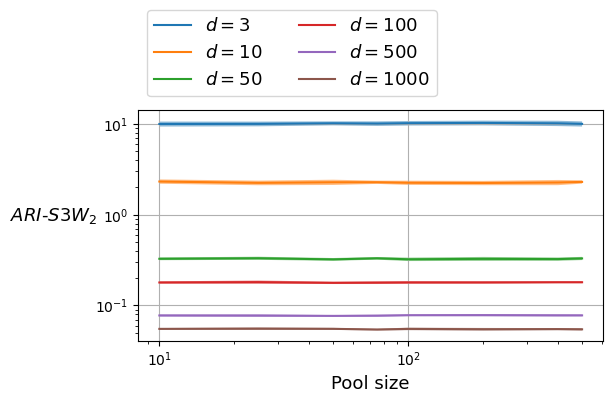

In [ ]:
fig = plt.figure(figsize=(6,3))

kappa = 5
ds = [3, 10, 50, 100, 500, 1000]
pools = [10,25,50,75,100,200,400,500]

L = np.zeros((len(ds), len(pools), 20))

for i, d in enumerate(ds):
    print(d)
    x0 = torch.randn((500,d), device=device)
    x0 = F.normalize(x0, p=2, dim=-1)
    
    mu = np.ones((d,))
    mu = mu/np.linalg.norm(mu)
    x1 = vmf_utils.rand_vmf(mu, kappa=kappa, N=500)
    
    for l, n_pools in enumerate(pools):
        for j in range(20):
            sw = s3w.ari_s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_rotations=10, pool_size=n_pools, device=device, n_projs=10) ** 0.5
            L[i,l,j] = sw

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)

    plt.plot(pools, m, label=r"$d=$"+str(d)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(pools, m-s, m+s,alpha=0.5)

plt.xlabel("Pool size", fontsize=13)
plt.ylabel(r"$ARI$-$S3W_2$", fontsize=13, rotation=0, labelpad=30)
plt.yscale("log")
plt.xscale("log")
    
plt.legend(fontsize=13, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2)
plt.grid(True)
plt.savefig("./ARI_S3W_Projection_Evol_Dim.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Runtime

3
10
50
100
500
1000


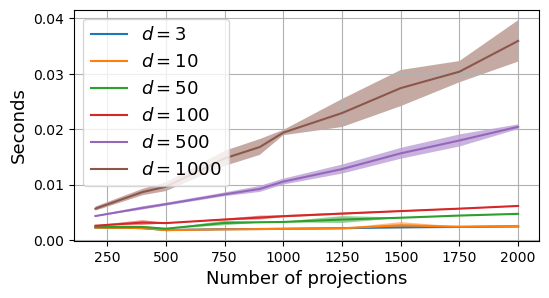

In [ ]:
fig = plt.figure(figsize=(6,3))

ntry = 50
kappa = 10
ds = [3, 10, 50, 100, 500, 1000]
projs = [200,400,500,750,900,1000,1250,1500,1750,2000]

L = np.zeros((len(ds), len(projs), ntry))

for i, d in enumerate(ds):
    print(d)

    x0 = torch.randn((500, d), device=device)
    x0 = F.normalize(x0, p=2, dim=-1)
    
    mu = np.ones(( d,))
    mu = mu/np.linalg.norm(mu)
    x1 = vmf_utils.rand_vmf(mu, kappa=kappa, N=500)
    
    for l, n_projs in enumerate(projs):
        # print(n_projs)
        for j in range(ntry):
            t0 = time.time()
            try:
                sw = s3w.s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=n_projs, device=device)
                L[i,l,j] = time.time()-t0
            except:
                L[i, l, j] = np.inf

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)

    plt.plot(projs, m, label=r"$d=$"+str(d)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(projs, m-s, m+s,alpha=0.5)
    plt.xlabel("Number of projections", fontsize=13)
    plt.ylabel("Seconds", fontsize=13)
    # plt.yscale("log")
    # plt.xscale("log")
    
plt.legend(fontsize=13)
plt.grid(True)
# plt.title("Computational Time", fontsize=13)
plt.savefig("./S3W_time_projections2.pdf", format="pdf", bbox_inches="tight")
plt.show()

3
10
50
100
500
1000


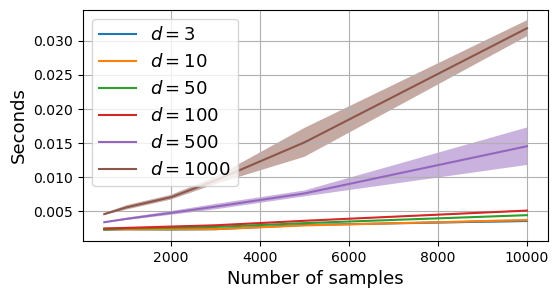

In [ ]:
fig = plt.figure(figsize=(6,3))

kappa = 10
ds = [3, 10, 50, 100, 500, 1000]
samples = [500,1000,2000,3000,5000,10000]
n_projs = 100

L = np.zeros((len(ds), len(samples), 20))

for i, d in enumerate(ds):
    print(d)
    mu = np.ones((d,))
    mu = mu/np.linalg.norm(mu)
    
    for k, n_samples in enumerate(samples):   
        
        x0 = torch.randn((n_samples, d), device=device)
        x0 = F.normalize(x0, p=2, dim=-1)
        
        x1 = vmf_utils.rand_vmf(mu, kappa=kappa, N=n_samples)
    
        for j in range(20):
            t0 = time.time()
            sw = s3w.s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=n_projs, device=device)
            L[i,k,j] = time.time()-t0

            # t1 = time.time()
            # ip = x0@torch.tensor(x1, dtype=torch.float, device=device).T
            # M = torch.arccos(torch.clamp(ip, min=-1+1e-5, max=1-1e-5))
            # a = torch.ones(x0.shape[0], device=device) / x0.shape[0]
            # b = torch.ones(x1.shape[0], device=device) / x1.shape[0]
            # w = ot.emd2(a, b, M).item()
            # L_w[i,k,j] = time.time()-t1

            # print(L[i,k,j], L_w[i,k,j])

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)

    plt.plot(samples, m, label=r"$d=$"+str(d)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(samples, m-s, m+s,alpha=0.5)
    plt.xlabel("Number of samples", fontsize=13)
    plt.ylabel("Seconds", fontsize=13)
    # plt.yscale("log")
    # plt.xscale("log")
    
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("./S3W_time_samples2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,3))

kappa = 10
ds = [3, 10, 50, 100, 500, 1000]
n_samples = 500
n_projs = 100
n_rots = [1, 10, 50, 100, 200, 300, 400, 500, 750, 1000]

L = np.zeros((len(ds), len(n_rots), 20))
L_w = np.zeros((len(ds), len(n_rots), 20))

for i, d in enumerate(ds):
    print(d)
    mu = np.ones((d,))
    mu = mu/np.linalg.norm(mu)
    
    for k, n_rot in enumerate(n_rots):   
        
        x0 = torch.randn((n_samples, d), device=device)
        x0 = F.normalize(x0, p=2, dim=-1)
        
        x1 = vmf_utils.rand_vmf(mu, kappa=kappa, N=n_samples)
    
        for j in range(20):
            t0 = time.time()
            sw = s3w.ri_s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=n_projs, n_rotations=n_rot, device=device)
            L[i,k,j] = time.time()-t0

            # t1 = time.time()
            # ip = x0@torch.tensor(x1, dtype=torch.float, device=device).T
            # M = torch.arccos(torch.clamp(ip, min=-1+1e-5, max=1-1e-5))
            # a = torch.ones(x0.shape[0], device=device) / x0.shape[0]
            # b = torch.ones(x1.shape[0], device=device) / x1.shape[0]
            # w = ot.emd2(a, b, M).item()
            # L_w[i,k,j] = time.time()-t1

            # print(L[i,k,j], L_w[i,k,j])

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)

    plt.plot(n_rots, m, label=r"$d=$"+str(d)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(n_rots, m-s, m+s,alpha=0.5)
    plt.xlabel("Number of rotations", fontsize=13)
    plt.ylabel("Seconds", fontsize=13)
    # plt.yscale("log")
    # plt.xscale("log")
    
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("./RIS3W_time_rotations.pdf", format="pdf", bbox_inches="tight")
plt.show()

3
10
50
100
500
1000


3
10
50
100
500
1000


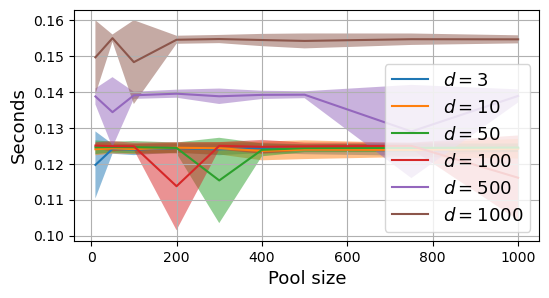

In [ ]:
fig = plt.figure(figsize=(6,3))

kappa = 10
ds = [3, 10, 50, 100, 500, 1000]
n_samples = 500
n_projs = 100
n_pools = [10, 50, 100, 200, 300, 400, 500, 750, 1000]

L = np.zeros((len(ds), len(n_pools), 50))

for i, d in enumerate(ds):
    print(d)
    mu = np.ones((d,))
    mu = mu/np.linalg.norm(mu)
    
    for k, n_pool in enumerate(n_pools):
        
        x0 = torch.randn((n_samples, d), device=device)
        x0 = F.normalize(x0, p=2, dim=-1)
        
        x1 = vmf_utils.rand_vmf(mu, kappa=kappa, N=n_samples)
    
        s3w.ari_s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=n_projs, n_rotations=10, device=device, pool_size=n_pool)

        for j in range(50):
            t0 = time.time()
            sw = s3w.ari_s3wd(x0, torch.tensor(x1, dtype=torch.float, device=device), p=2, n_projs=n_projs, n_rotations=10, device=device, pool_size=n_pool)
            L[i,k,j] = time.time()-t0

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)

    plt.plot(n_pools, m, label=r"$d=$"+str(d)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(n_pools, m-s, m+s,alpha=0.5)
    plt.xlabel("Pool size", fontsize=13)
    plt.ylabel("Seconds", fontsize=13)
    # plt.yscale("log")
    # plt.xscale("log")
    
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("./ARIS3W_time_pool.pdf", format="pdf", bbox_inches="tight")
plt.show()

3
10
50
100
500
1000


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.73 GiB. GPU 3 has a total capacty of 47.54 GiB of which 3.65 GiB is free. Process 1692905 has 7.81 GiB memory in use. Process 1693390 has 8.01 GiB memory in use. Process 1693871 has 7.82 GiB memory in use. Process 1694353 has 7.84 GiB memory in use. Process 1694879 has 7.56 GiB memory in use. Including non-PyTorch memory, this process has 4.83 GiB memory in use. Of the allocated memory 2.80 GiB is allocated by PyTorch, and 964.94 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

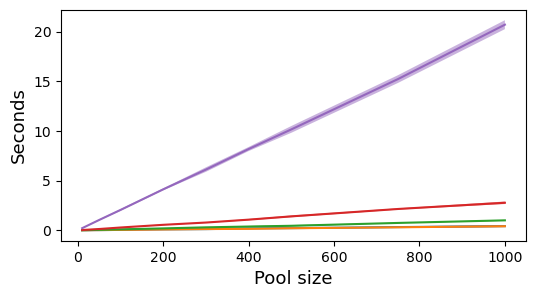

In [17]:
fig = plt.figure(figsize=(6,3))

ds = [3, 10, 50, 100, 500, 1000]
n_pools = [10, 50, 100, 200, 300, 400, 500, 750, 1000]

L = np.zeros((len(ds), len(n_pools), 20))

for i, d in enumerate(ds):
    print(d)
    for k, n_pool in enumerate(n_pools):
        for j in range(20):
            t0 = time.time()
            sw = RotationPool.get(d, n_pool, device=device)
            L[i,k,j] = time.time()-t0

            RotationPool.reset()

    m = np.mean(L[i], axis=-1)
    s = np.std(L[i], axis=-1)

    plt.plot(n_pools, m, label=r"$d=$"+str(d)) # + r" $\mu=$["+str(mu[0])+","+str(mu[1])+","+str(mu[2])+"]")
    plt.fill_between(n_pools, m-s, m+s,alpha=0.5)
    plt.xlabel("Pool size", fontsize=13)
    plt.ylabel("Seconds", fontsize=13)
    # plt.yscale("log")
    # plt.xscale("log")
    
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("./ARIS3W_time_pool_generation.pdf", format="pdf", bbox_inches="tight")
plt.show()